# Damage transport test

This notebook tests icepack's Damage Transport module in an application similar to Figure 3 in [Miele et al., 2023](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022JF006959). That is, we consider a rectangular ice shelf whose sidewalls provide friction over only a limited subset of the domain. The shelf experiences high extensional strain rate and tension as it exits the zone of maximum sidewall resistance. Here, we assume that the extension causes some degree of fracture density, which, in turn, effectively softens the ice, as described by [Albrecht and Levermann](https://www.cambridge.org/core/journals/journal-of-glaciology/article/fracture-field-for-largescale-ice-dynamics/ED82A8928F6C65EFA3817CC02745956D), and implemented [in this icepack tutorial](https://icepack.github.io/notebooks/tutorials/02-synthetic-ice-shelf/). 

## Imports

In [1]:
path = '/home/sermilik/firedrake_stuff/figures/flow_flexure' #modify to preferred destination for saving figs

from firedrake import *
import icepack
from icepack.calculus import sym_grad
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import os
import tqdm #displays progress bars in long-running loops

## Mesh, function spaces, trial and test functions

The shelf will be rectangular, with length ```Lx``` and width ```Ly```.

In [2]:
nx, ny = 30, 15 #number of elements in x, y
Lx, Ly = 6000, 3000 #length, width in meters
mesh = RectangleMesh(nx, ny, Lx, Ly)
x, y = SpatialCoordinate(mesh)

Q = FunctionSpace(mesh, 'CG', 2) #CG elements
V = VectorFunctionSpace(mesh, 'CG', 2)  #CG elements for solving SSA problem
S = TensorFunctionSpace(mesh, 'DG', 1) #DG elements for interpolating tensors arising from the velocity field

u = Function(V) #velocity
v = TestFunction(V) #note the Roman v, not to be confused with Greek ν introduced below

## Physical constants, shelf geometry

In [3]:
from icepack.constants import year #number of seconds in a year
T = Constant(273.15) #temperature (K). 273.15 is freezing
A = icepack.rate_factor(T) #A from Glen's law

H_gl = 500 #thickness at upstream boundary (m)
thick_grad = -0.0 #thickness gradient 
H0 = project(H_gl + thick_grad*x, Q) #initial thickness projected onto CG elements

## Modify some icepack modules to incorporate damage

Allow damage softening with modified viscosity, ```viscosity_damaged``` (see [this icepack tutorial](https://icepack.github.io/notebooks/tutorials/02-synthetic-ice-shelf/)). Also, write a function that returns the effective viscosity (we'll need this to calculate membrane stresses, and, therefore, fracture density). 

In [4]:
def viscosity_damaged(**kwargs):
    n = 3 #glen's law exponent
    u, h, A, D = itemgetter('velocity', 'thickness', 'fluidity', 'damage')(kwargs)
    A_damaged = (1 - D)**(-n)*A
    return icepack.models.viscosity.viscosity_depth_averaged(velocity = u, thickness = h, 
                                                             fluidity = A_damaged)
    
def effective_viscosity(**kwargs): #also define a function that returns the effective viscosity
    n = 3
    u, D = itemgetter('velocity', 'damage')(kwargs)
    ε = sym(grad(u))
    ε_min = Constant(kwargs.get('strain_rate_min', icepack.constants.strain_rate_min))
    ε_e = icepack.models.viscosity._effective_strain_rate(ε, ε_min) 
    A_damaged = (1 - D)**(-n)
    ν = 1/2*A_damaged**(-1/n)*ε_e**(1/n - 1) #effective viscosity in MPa*yrs
    return ν #return ν in units of MPa*yrs

## Set up the solver

The key to the setup here is to impose a spatially variable coefficient of sidewall friction. The coefficient of sidewall friction will be zero at the upstream and downstream boundaries of the domain, but it will briefly rise to some baseline value at the center of the domain (see output figure below).

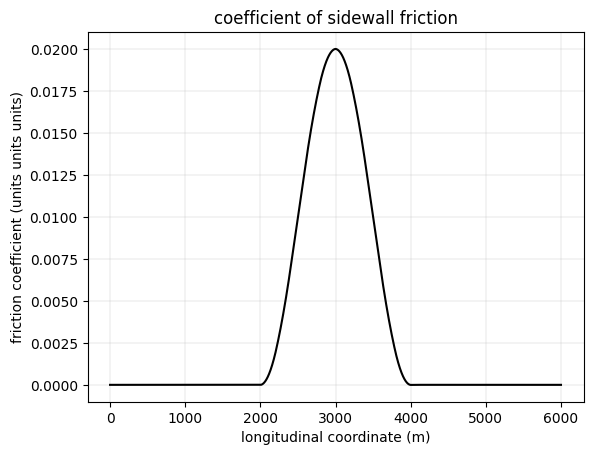

In [5]:
################################
################################
### parameters for iteration ###
################################
################################

Δt = 1/10 #length of timestep in years
num_timesteps = int(20/Δt) #spin up for 20 years

##########################
##########################
### set up flow solver ###
##########################
##########################

ux_gl = 100 #upstream boundary boundary condition in meters per year
u0 = project(as_vector([ux_gl, 1e-50]), V) #initial velocity (u_x, u_y) for imposing Dirichlet BCs

C0 = 0.02 #maximum coefficient of sidewall friction
px, r = Lx/2, 1000 #x-coordinate of max friction, length of ramp-up
C = Function(Q).project(
    conditional(abs(x - px) <= r, 1/2*C0*cos(pi*(x - px)/r) + 1/2*C0, 0)) #(see output figure below)

opts = {
    'dirichlet_ids': [1], #boundaries are labeled (1, 2, 3, 4) = (upstream, downstream, left, right)
    'side_wall_ids': [3, 4],
    'ice_front_ids': [2],
    #'diagnostic_solver_type': 'petsc',
    'diagnostic_solver_parameters': {
        'ksp_type': 'cg',
        'pc_type': 'mg',
        'pc_mg_cycle_type': 'w',
        'snes_line_search_type': 'cp',
    },
    'prognostic_solver_parameters': {
        'ksp_type': 'gmres',
        'pc_type': 'ilu',
    },
}

flow_model = icepack.models.IceShelf(viscosity = viscosity_damaged)
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

############################
############################
### set up damage solver ###
############################
############################

damage_model = icepack.models.DamageTransport() #accept all of icepack's defaults
damage_solver = icepack.solvers.DamageSolver(damage_model)
D0 = Function(Q).project(Constant(0))

####################################
####################################
### display friction coefficient ###
####################################
####################################

os.chdir(path) #for saving figures
X = np.array([(k, Ly/2) for k in range (Lx+1)]) #along-flow line for getting geometry profiles
C_profile = np.array(C.at(X, tolerance = 1e-10))

plt.figure()
plt.title('coefficient of sidewall friction')
plt.plot(C_profile, color='k', label = 'friction')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('friction coefficient (units units units)')
plt.grid(linewidth=0.2)

## Iteratively solve

We'll simultaneously solve two problems: one in which the shelf's rheology is altered by damage, and one in which it is not. The highest fracture density occurs at the sidewalls beyond the location of maximal friction, softening the downstream margins. Consequently, the downstream part of the damaged shelf will flow slightly faster than the undamaged version.

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [03:05<00:00,  1.08it/s]


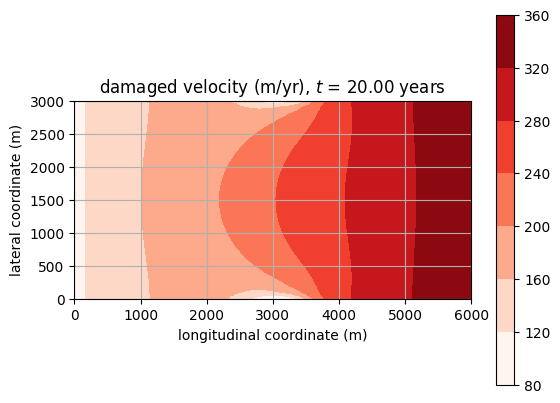

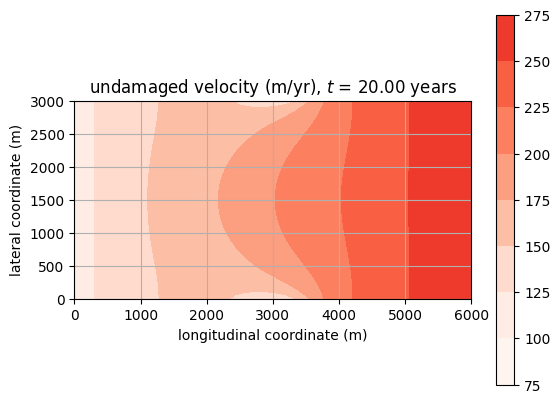

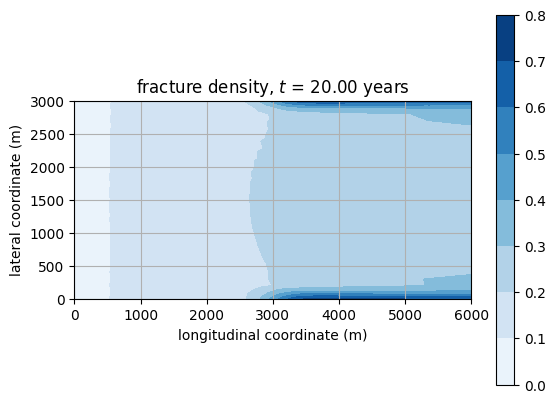

In [6]:
u_damaged, H_damaged = u0.copy(deepcopy=True), H0.copy(deepcopy=True)
u_intact, H_intact = u0.copy(deepcopy=True), H0.copy(deepcopy=True)
D = D0.copy(deepcopy=True)

for step in tqdm.trange(num_timesteps):
    
    #############################
    #############################
    ### get velocity solution ###
    #############################
    #############################
    
    u_damaged = flow_solver.diagnostic_solve(velocity = u_damaged, side_friction = C, #let damage impact this velocity solution
                                thickness = H_damaged, fluidity = A, damage = D)

    u_intact = flow_solver.diagnostic_solve(velocity = u_intact, side_friction = C, #but not this one
                            thickness = H_intact, fluidity = A, damage = Constant(0))

    
    ##################################
    ##################################
    ### dynamically thin the shelf ###
    ##################################
    ##################################

    H_damaged = flow_solver.prognostic_solve(Δt, thickness = H_damaged, velocity = u_damaged, #uses damaged velocity field
                           thickness_inflow = H0, accumulation = Constant(0))
    
    H_intact = flow_solver.prognostic_solve(Δt, thickness = H_intact, velocity = u_intact, #uses undamaged velocity field 
                           thickness_inflow = H0, accumulation = Constant(0))

    ########################################
    ########################################
    ### calculate some useful parameters ###
    ########################################
    ########################################

    ν_damaged = effective_viscosity(velocity = u_damaged, damage = D) #in MPa*yrs
    ε_damaged = Function(S).project(sym(grad(u_damaged))) #strain rate tensor, /yr
    τ_damaged = Function(S).project(2*ν_damaged*ε_damaged) #depth-averaged deviatoric stress tensor in MPa

    ###########################
    ###########################
    ### update damage field ###
    ###########################
    ###########################
    
    D = damage_solver.solve(Δt, velocity = u_damaged, 
                         damage = D, 
                         strain_rate = ε_damaged, 
                         membrane_stress = τ_damaged, 
                         damage_inflow = Constant(0))
        
    #################
    #################
    ### save figs ###
    #################
    #################
    
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    vel_plot = tricontourf(u_damaged, axes = ax, cmap = 'Reds', vmin = 100, vmax = 360) #damaged velocity plot
    plt.colorbar(vel_plot)
    plt.title('damaged velocity (m/yr), $t$ = {:.2f} years'.format(step*Δt + Δt))
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('lateral coordinate (m)')
    plt.grid()
    plt.savefig('vel_damaged_iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close()

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    vel_plot = tricontourf(u_intact, axes = ax, cmap = 'Reds', vmin = 100, vmax = 360) #undamaged velocity plot
    plt.colorbar(vel_plot)
    plt.title('undamaged velocity (m/yr), $t$ = {:.2f} years'.format(step*Δt + Δt))
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('lateral coordinate (m)')
    plt.grid()
    plt.savefig('vel_undamaged_iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close()

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    frac_plot = tricontourf(D, axes = ax, cmap = 'Blues', vmin = 0, vmax = 0.8) #damage plot
    plt.colorbar(frac_plot)
    plt.title('fracture density, $t$ = {:.2f} years'.format(step*Δt + Δt))
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('lateral coordinate (m)')
    plt.grid()
    plt.savefig('fracture_iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close()